In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

import numpy as np
import math
import random
import gym
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple
from itertools import count
from PIL import Image

In [2]:
env = gym.make('CartPole-v0').unwrapped

# Setup matplotlib.
is_python = 'inline' in matplotlib.get_backend()
if is_python:
    from IPython import display

plt.ion()

# If GPU is to be used.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Reply Memory

We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing
us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has
been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we’re going to need two classses:

- __Transition__ - a named tuple representing a single transition in our environment. It essentially maps (state, action)
pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.
- __ReplayMemory__ - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a
```.sample()``` method for selecting a random batch of transitions for training.

In [3]:
transitions = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

    def push(self, *args):
        """
        Save transitions.
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = transitions(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


## Q-network

Our model will be a convolutional neural network that takes in the difference between the current and previous screen
patches. It has two outputs, representing ``Q(s,left)`` and ``Q(s,right)`` (where ``s`` is the input to the network).
In effect, the network is trying to predict the expected return of taking each action given the current input.

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size + 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))

        linear_input_size = convh * convw * 32
        self.head = nn.Linear(in_features=linear_input_size, out_features=outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## Input Extraction

The code below are utilities for extracting and processing rendered images from the environment. It uses the ``torchvision``
package, which makes it easy to compose image transforms. Once you run the cell, it will display an example patch that
it extracted

Text(0.5, 1.0, 'Example Extracted Screen')

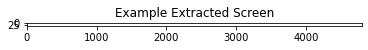

In [5]:
resize = T.Compose([
    T.ToPILImage(),
    T.Resize(40, interpolation=Image.CUBIC),
    T.ToTensor()
])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0 ) # MIDDLE OF THE CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((1, 2, 0))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height * 0.4):int(screen_width * 0.8)]

    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)

    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width) // 2:
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)

    # Strip off the edges, so that we have a square image centered on a cart.
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)

    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation=None)
plt.title("Example Extracted Screen")

## Training
### Hyperparameters and Utilities
